# 🏨 Dynamic Hotel Pricing Optimization
## 🚀 Advanced Elasticity Modeling → XGBoost Regressor

**Goal:** Model complex, non-linear price elasticity using XGBoost.


In [3]:
# 1️⃣ Load Data
import pandas as pd

df = pd.read_csv('../data/raw/hotel_bookings.csv')

# Filter to completed bookings
df = df[df['is_canceled'] == 0]

# Basic feature engineering
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['day_of_week'] = df['reservation_status_date'].dt.dayofweek
df['month'] = df['reservation_status_date'].dt.month
df['stay_length'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# Keep useful columns
df_model = df[['adr', 'lead_time', 'day_of_week', 'month', 'stay_length', 'market_segment', 'hotel']].copy()


In [4]:
# 2️⃣ Encode categorical features

from sklearn.preprocessing import LabelEncoder

df_model['market_segment_encoded'] = LabelEncoder().fit_transform(df_model['market_segment'])
df_model['hotel_encoded'] = LabelEncoder().fit_transform(df_model['hotel'])


In [5]:
# 3️⃣ Aggregate Bookings by Price & Features

# Group data → each row will represent (adr, segment, hotel, etc.) → number of bookings
# You can also do this as a time series → here simple aggregate per combination:

agg_df = df_model.groupby(['adr', 'market_segment_encoded', 'hotel_encoded', 'day_of_week', 'month']) \
    .size().reset_index(name='bookings')

agg_df.head()


,adr,market_segment_encoded,hotel_encoded,day_of_week,month,bookings
0,-6.38,4,1,2,3,1
1,0.00,0,0,1,11,1
2,0.00,0,0,2,6,3
3,0.00,0,0,4,7,1
4,0.00,1,0,0,1,1


In [7]:
# 4️⃣ Train XGBoost Regressor

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Features and target
features = ['adr', 'market_segment_encoded', 'hotel_encoded', 'day_of_week', 'month']
X = agg_df[features]
y = agg_df['bookings']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation → safe for all sklearn versions
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse:.2f}')


RMSE: 2.99


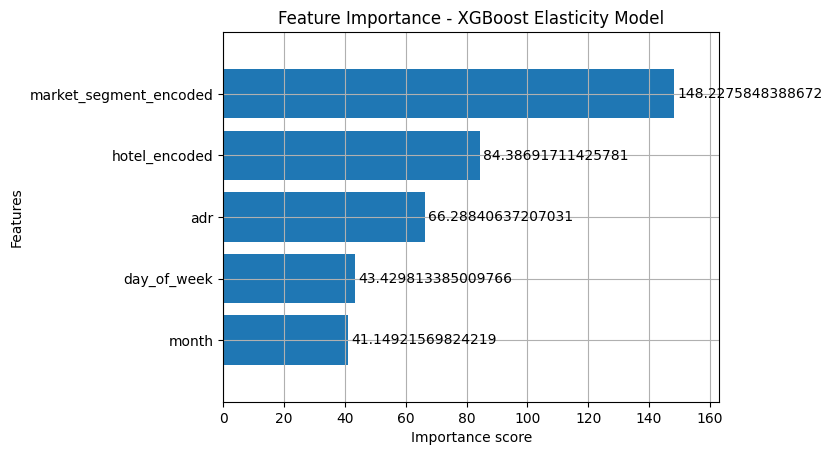

In [8]:
# 5️⃣ Feature Importance → Business friendly

import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, importance_type='gain', height=0.8)
plt.title('Feature Importance - XGBoost Elasticity Model')
plt.show()


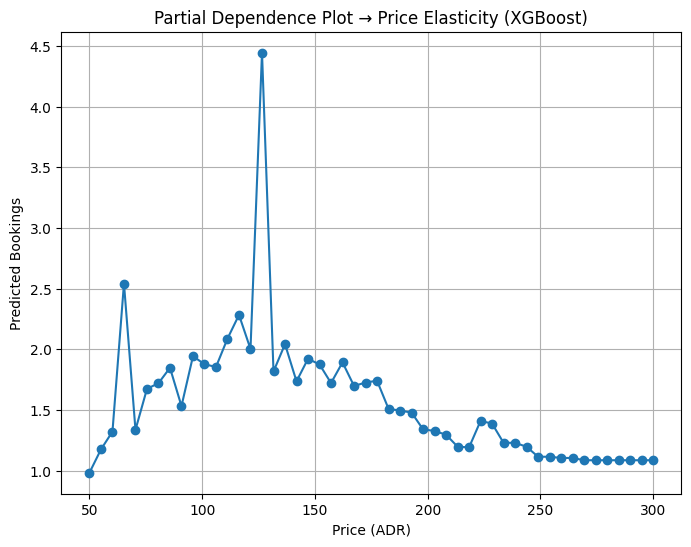

In [9]:
# 6️⃣ Partial Dependence Plot for Price (adr)

# Advanced way → use sklearn PartialDependenceDisplay if using sklearn interface
# For now → manual simple PDP

import numpy as np

adr_values = np.linspace(50, 300, 50)
pdp_values = []

# Fix other features at typical values (e.g., most common segment/hotel, median day/month)
default_segment = agg_df['market_segment_encoded'].mode()[0]
default_hotel = agg_df['hotel_encoded'].mode()[0]
default_day = 3  # mid-week
default_month = 6  # summer

for adr in adr_values:
    row = pd.DataFrame({
        'adr': [adr],
        'market_segment_encoded': [default_segment],
        'hotel_encoded': [default_hotel],
        'day_of_week': [default_day],
        'month': [default_month]
    })
    
    pred = model.predict(row)[0]
    pdp_values.append(pred)

# Plot PDP
plt.figure(figsize=(8,6))
plt.plot(adr_values, pdp_values, marker='o')
plt.title('Partial Dependence Plot → Price Elasticity (XGBoost)')
plt.xlabel('Price (ADR)')
plt.ylabel('Predicted Bookings')
plt.grid()
plt.show()
